# ChatGPT resource for creating API Extension
https://chatgpt.com/share/683daea4-c88c-8009-a08c-a6abaaf8fac1

# Functions to Implement for iiFBA useage
2 Functions
- Simpler: Indexed
- With Sampling
  

### Equations

#### Indexed Version:
Original conceptualization of IIFBA equation

$\large{f_{n+1,j}=(1-\alpha)[f_{n,j}-\sum_{i} R_{i} F_{n,i,j}(f_{n,j},S_i)]+\alpha f_{0,j}}$

* Variables:
    * $f_{n,j}$: the exchange flux bound for j-th metabolite in n-th environment iteration
    * $R_{i}$: relative abundance of i-th organism
    * $F_{n,i,j}$: exchange flux of i-th organism for j-th metablite simulated in environment iteration n, as a function of the exchange flux bounds and metabolic model $S_i$
* Parameters:
    * $\alpha$: flow factor (trade-off between updated and original environment)
* Input:
    * $f_{0,j}$: exchange flux bounds for j-th metabolite in initial environment
    * $R$: relative abundance vector
    * $S$: metabolic models
* Output:
    * F: flux list with matrix of fluxes by iteration for each organism
    * f: environment fluxes, matrix of exchange fluxes by iteration

#### Matrix Version:
Vectorized form of the IIFBA equation

$\large{f_{n+1}=(1-\alpha)[f_{n}- R F_{n}(f_{n},S)]+\alpha f_{0}}$

* Matrix Variables:
    * $f_{n}$: vector of exchange flux bounds for all metabolites in n-th environment iteration
    * $R$: vector of relative abundances for all organisms
    * $F_{n}$: matrix of organisms by exchanges for  fluxes simulated in n-th environment iteration as a function of the exchange flux bounds and organism metabolic models $S$
* Parameters:
    * $\alpha$: flow factor (trade-off between updated and original environment)
* Input:
    * $f_{0}$: exchange flux bounds vector for initial environment
    * $R$: relative abundance vector
* Output:
    * F: flux list with matrix of fluxes by iteration for each organism
    * f: environment fluxes, matrix of exchange fluxes by iteration

## Function


In [1]:
import cobra as cb
import numpy as np
import pandas as pd


In [2]:
# model_pre_processing
mod_paths = ['../AGORA2_Models/Escherichia_coli_str_K_12_substr_MG1655.mat']#,
             #"../AGORA2_Models/Bacteroides_thetaiotaomicron_3731.mat"]
S_matrix = [] #list of models
# Load Models and Save in S vector
for i in range(len(mod_paths)):
    model = cb.io.load_matlab_model(mod_paths[i])
    S_matrix.append(model) #append models to list

# Define input environment f_0
# this should be defined as a pandas dataframe with columns "Reaction" and "LB"
# glucose minimal medium
# Define Medium Components
glc_min_med = ['EX_glc_D(e)','EX_so4(e)','EX_nh4(e)','EX_no3(e)','EX_pi(e)','EX_cys_L(e)',
               'EX_mn2(e)','EX_cl(e)','EX_ca2(e)','EX_mg2(e)','EX_cu2(e)','EX_cobalt2(e)','EX_fe2(e)','EX_fe3(e)','EX_zn2(e)','EX_k(e)']
# Define medium uptake flux bounds
glc_min_med_flux = [-10,-100,-100,-100,-100,-100,
                    -100,-100,-100,-100,-100,-100,-100,-100,-100,-100]
glc_f0 = pd.DataFrame(data={'Reaction': glc_min_med,'LB': glc_min_med_flux})

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, p


In [6]:
# Simple non-sampling
def iifba(community_model, media, relative_abundance,
          flow=0.5, solution_type="pFBA", 
          iterations=10,
          m_vals=[1,1], v=False):
    """
    Summary:

    
    Params:
    - community_model: LIST type of Cobra Models (len number of unique bacteria)
    descr.

    - media: pd.DataFrame ()
    descr.

    - relative_abundance: LIST type of FLOAT (len number of unique bacteria)
    relative abundances of each bacteria in community. If sum(relative_abundance) > 1,
    relative abundances will be scaled by the sum. 

    - flow (optional): FLOAT
    default = 0.5
    Input flow rate of new metabolites/exchanges in media

    - solution type (optional): STR
    default = "pFBA"
    Type of optimization for FLux balance
    can be "pFBA", "sampling"

    - iterations (optional): INT
    default = 10
    THe number of interations until completion. Must be greater than 1 iteration.

    - m_vals (optional): LIST type of INT (2,)
    default = [1, 1]
    Number of initial flux points to use in flux sampling and number of runs per 
    iterations. If both values are 1, then simple 1-to-1 iterations are done.

    - v (optional) BOOL
    default = False
    Turn on verbose or turn off

    
    Returns:
    - flux_log: pandas.Dataframe 
    Contains values of all fluxes in exchanges of the community. Dataframe is
    multi-indexed by (iteration, run), run will always be 0 if using pFBA.

    - F: LIST of pandas.Dataframe
    Each index of list corresponds to the model of community_model. Each dataframe 
    contains all the fluxes of the appropriate model. Dataframe is multi-indexed 
    by (iteration, run), run will always be 0 if using pFBA.

    
    """
    # convert all numeric to ints to ensure proper variable useage
    m_vals[0] = int(m_vals[0])
    m_vals[1] = int(m_vals[1])
    iterations = int(iterations)
    if solution_type.lower() == "pfba":
        print("Using Parsimonious FBA")
        m_vals = [1,1]
    elif solution_type.lower() == "sampling":
        print("Using Flux Sampling")
    else:
        print("Defaulting to Using Parsimonious FBA")
        solution_type = "pfba"
    solution_type = solution_type.lower()

    if sum(relative_abundance) >1:
        print("Scaling Abundance") if v else None
        relative_abundance = [r/sum(relative_abundance) for r in relative_abundance]

    print("Initializing Iterations") if v else None
    M = np.zeros((m_vals[0], iterations -1), dtype=int)
    for i in range(iterations-1):
        Mcol = np.sort(np.random.choice(m_vals[0]*m_vals[1],m_vals[0],replace=False))
        M[:,i]=Mcol
        

    # store fluxes of all exchange reactions for the overall model based on media
    print("Initializing Exchanges Logging") if v else None
    arrays = [[0]*m_vals[0]*m_vals[1],list(range(m_vals[0]*m_vals[1]))]
    tuples = list(zip(*arrays))
    multi_idx = pd.MultiIndex.from_tuples(tuples,names=['iteration','run'])

    # extract all exchange reactions
    cols = set()
    for model_idx in range(len(community_model)):
        for model_ex in range(len(community_model[model_idx].exchanges)):
            cols.add(community_model[model_idx].exchanges[model_ex].id)

    # compile initial media conditions
    print("Initializing Environment Logging") if v else None
    flux_log = pd.DataFrame([np.zeros(len(cols))],
                     columns=list(cols),
                     index=multi_idx,dtype=float)
    for media_ex in range(len(media)):
        exid = media.iloc[media_ex]['Reaction']
        ex_flux = media.iloc[media_ex]['LB']
        flux_log.loc[:,exid] = ex_flux
    
    # initialize organism flux dataframes
    F = []  

    # iterations
    print("Running Iterations") if v else None
    for iter in range(iterations):
        print("Iteration:", iter)
        
        if iter == 0:
            # use media for the first time around for all models
            for org_idx in range(len(community_model)):
                print("Organism:", org_idx)
                with community_model[org_idx] as model_iter:
                    # reset exchanges for environment setting
                    print("Reset Exchanges") if v else None
                    for ex in model_iter.exchanges:
                        ex.lower_bound = 0
                        ex.upper_bound = 1000
                    
                    # Set Environment for 0th run (same initial env. for all runs)
                    print("Set Environment") if v else None
                    for env_ex in range(len(flux_log.columns)):
                        ex_lb = flux_log.loc[(0,0)][flux_log.columns[env_ex]] #initial environment is the same for all runs, so use the 0th run
                        if ex_lb != 0:
                            ex_id = flux_log.columns[env_ex]
                            if ex_id in model_iter.exchanges:
                                model_iter.exchanges.get_by_id(ex_id).lower_bound = ex_lb
                    
                    # run optimization with pfba
                    if solution_type == 'pfba':
                        print("Running Optimization") if v else None
                        multi_idx = pd.MultiIndex.from_tuples([(0,0)],names=["iteration","run"])                                       
                        # run pFBA
                        sol1 = model_iter.slim_optimize()
                        if sol1 > 0.001:
                            sol = cb.flux_analysis.parsimonious.pfba(model_iter)
                            # standardize and save output                   
                            df = pd.DataFrame([sol.fluxes],columns=sol.fluxes.index,index=multi_idx)
                            F.append(df)
                            print(df.shape)
                        else:
                            # if no growth and cannot use the solution
                            rxnid = []
                            for i in range(len(model_iter.reactions)): 
                                rxnid.append(model_iter.reactions[i].id)
                            df = pd.DataFrame([np.zeros(len(model_iter.reactions))],columns=rxnid,index=multi_idx)
                            F.append(df)
                            print(df.shape)
                    print(len(F))
                    # run optimization with flux sampling
                    if solution_type == 'sampling':
                        print("Running Optimization") if v else None
                        # run flux sampling
                        sol = cb.sampling.sample(model_iter, m_vals[0]*m_vals[1])
                        print(sol.index)
                        # standardize and save output
                        arrays = [[0]*m_vals[0]*m_vals[1],list(sol.index)]
                        tuples = list(zip(*arrays))
                        multi_idx = pd.MultiIndex.from_tuples(tuples,names=['iteration','run'])
                        sol.index = multi_idx
                        F.append(sol)

            # update f
            for run_idx in range(m_vals[0]*m_vals[1]): 
                print("Updating Fluxes") if v else None
                env_tmp = flux_log.loc[[(iter,0)]].copy(deep=True) #temporary dataframe for base environment from iteration 0,0
                for env_ex in range(len(flux_log.columns)):# for each exchange flux in environment
                    ex_flux_sum = 0
                    ex_flux_id = flux_log.columns[env_ex]
                    #sum total flux of all bacteria in model
                    for org_idx in range(len(community_model)):# for each organism sum up flux * relative abundance
                        if ex_flux_id in community_model[org_idx].exchanges:
                            if F[org_idx].loc[(0,run_idx)][ex_flux_id] != 0:
                                ex_flux_sum += F[org_idx].loc[(0,run_idx)][ex_flux_id] * relative_abundance[org_idx]

                    #iifba update for ex
                    env_tmp.loc[(0,0),ex_flux_id] = (1-flow)*(flux_log.loc[(0,0)][ex_flux_id].item()-ex_flux_sum) + flow*flux_log.loc[(0,0)][ex_flux_id].item() # update flux
                
                #re-index tmp dataframe
                multi_idx = pd.MultiIndex.from_tuples([(1,run_idx)],names=["iteration","run"])
                df_tt = pd.DataFrame([env_tmp.loc[(0,0)]],columns = env_tmp.columns, index = multi_idx)
                flux_log = pd.concat([flux_log,df_tt])
        
        # re-run for other iterations
        else:       
            # if flux sampling, repeat for multiple points
            for m1_idx in range(m_vals[0]):
                M_iter = M[m1_idx, iter-1]
                print(M_iter)

                # run iteration for all bacteria in community
                for org_idx in range(len(community_model)):
                    print('organism:',org_idx)

                    with community_model[org_idx] as model_iter:
                        # reset exchanges for environment setting
                        print("Reset Exchanges") if v else None
                        for ex in model_iter.exchanges:
                            ex.lower_bound = 0
                            ex.upper_bound = 1000
                    
                        # Set Environment
                        print("Set Environment") if v else None
                        for env_ex in range(len(flux_log.columns)):
                            ex_lb = flux_log.loc[(iter,M_iter)][flux_log.columns[env_ex]]
                            if ex_lb != 0:
                                ex_id = flux_log.columns[env_ex]
                                if ex_id in model_iter.exchanges:
                                    model_iter.exchanges.get_by_id(ex_id).lower_bound = ex_lb
                        

                        if solution_type == 'pfba':
                            print("Running Optimization") if v else None
                            multi_idx = pd.MultiIndex.from_tuples([(iter,0)],names=["iteration","run"])                                       
                            # run pFBA
                            sol1 = model_iter.slim_optimize()
                            if sol1 > 0.001:
                                sol = cb.flux_analysis.parsimonious.pfba(model_iter)
                                # standardize and save output                   
                                df = pd.DataFrame([sol.fluxes],columns=sol.fluxes.index,index=multi_idx)
                                F[org_idx] = pd.concat([F[org_idx],df])
                            else:
                                rxnid = []
                                for i in range(len(model_iter.reactions)): 
                                    rxnid.append(model_iter.reactions[i].id)
                                df = pd.DataFrame([np.zeros(len(model_iter.reactions))],columns=rxnid,index=multi_idx)
                                F[org_idx] = pd.concat([F[org_idx],df])

                        if solution_type == 'sampling':
                            print("Running Optimization") if v else None
                            # run flux sampling
                            sol = cb.sampling.sample(model_iter,m_vals[0])
                            # standardize and save output
                            arrays = [[iter]*m_vals[0]*m_vals[1],list(sol.index+m1_idx*m_vals[1])]
                            tuples = list(zip(*arrays))
                            multi_idx = pd.MultiIndex.from_tuples(tuples,names=['iteration','run'])
                            sol.index = multi_idx
                            F[org_idx] = pd.concat([F[org_idx],sol])
            
            # update fluxes
            for m2_idx in range(m_vals[1]):
                print("Updating Fluxes") if v else None
                env_tmp = flux_log.loc[[(iter,M_iter)]].copy(deep=True) #temporary dataframe for base environment from iteration 0,0
                for ex_idx in range(len(flux_log.columns)):# for each exchange flux in environment
                    ex_flux_sum = 0
                    ex_flux_id = flux_log.columns[ex_idx]
                    for org_idx in range(len(community_model)):# for each organism sum up flux * relative abundance
                        if ex_flux_id in community_model[org_idx].exchanges:
                            if F[org_idx].loc[(iter, m2_idx+m1_idx*m_vals[1])][ex_flux_id] != 0:
                                ex_flux_sum += F[org_idx].loc[(iter,m2_idx+m1_idx*m_vals[1])][ex_flux_id] * relative_abundance[org_idx]

                    env_tmp.loc[(iter,M_iter),ex_flux_id] = (1-flow)*(flux_log.loc[(iter,M_iter)][ex_flux_id].item()-ex_flux_sum) + flow*flux_log.loc[(0,0)][ex_flux_id].item() # update flux
                #re-index tmp dataframe
                multi_idx = pd.MultiIndex.from_tuples([(iter+1,m2_idx+m1_idx*m_vals[1])],names=["iteration","run"])
                df_tt = pd.DataFrame([env_tmp.loc[(iter,M_iter)]],columns = env_tmp.columns, index = multi_idx)
                flux_log = pd.concat([flux_log,df_tt])

    return flux_log, F

In [7]:
f_test, F_test = iifba(S_matrix, glc_f0, [1],
                  flow=0.5, solution_type="sampling", 
                  iterations=1,
                  m_vals=[1,1], v=False)

Using Flux Sampling
Iteration: 0
Organism: 0
0
RangeIndex(start=0, stop=1, step=1)


In [8]:
F_test[0]['biomass525']

iteration  run
0          0      0.784637
1          0      0.505684
2          0      0.472349
Name: biomass525, dtype: float64

### Clean Up Iter 0 Code
Lazy method for now with if/else to replace some vars


In [ ]:
# Condense iter 0 with the rest
def iifba(community_model, media, relative_abundance,
          flow=0.5, solution_type="pFBA", 
          iterations=10,
          m_vals=[1,1], v=False):
    """
    Summary:

    Params:
    - community_model: LIST type of Cobra Models (len number of unique bacteria)
    descr.

    - media: pd.DataFrame ()
    descr.

    - relative_abundance: LIST type of FLOAT (len number of unique bacteria)
    relative abundances of each bacteria in community. If sum(relative_abundance) > 1,
    relative abundances will be scaled by the sum. 

    - flow (optional): FLOAT
    default = 0.5
    Input flow rate of new metabolites/exchanges in media

    - solution type (optional): STR
    default = "pFBA"
    Type of optimization for FLux balance
    can be "pFBA", "sampling"

    - iterations (optional): INT
    default = 10
    THe number of interations until completion. Must be greater than 1 iteration.

    - m_vals (optional): LIST type of INT (2,)
    default = [1, 1]
    Number of initial flux points to use in flux sampling and number of runs per 
    iterations. If both values are 1, then simple 1-to-1 iterations are done.

    - v (optional) BOOL
    default = False
    Turn on verbose or turn off

    Returns:
    """
    # convert all numeric to ints to ensure proper variable useage
    m_vals[0] = int(m_vals[0])
    m_vals[1] = int(m_vals[1])
    iterations = int(iterations)
    if solution_type.lower() == "pfba":
        print("Using Parsimonious FBA")
        m_vals = [1,1]
    elif solution_type.lower() == "sampling":
        print("Using Flux Sampling")
    else:
        print("Defaulting to Using Parsimonious FBA")
        solution_type = "pfba"
    solution_type = solution_type.lower()

    if sum(relative_abundance) >1:
        print("Scaling Abundance") if v else None
        relative_abundance = [r/sum(relative_abundance) for r in relative_abundance]

    print("Initializing Iterations") if v else None
    M = np.zeros((m_vals[0], iterations -1), dtype=int)
    for i in range(iterations-1):
        Mcol = np.sort(np.random.choice(m_vals[0]*m_vals[1],m_vals[0],replace=False))
        M[:,i]=Mcol
        

    # store fluxes of all exchange reactions for the overall model based on media
    print("Initializing Exchanges Logging") if v else None
    arrays = [[0]*m_vals[0]*m_vals[1],list(range(m_vals[0]*m_vals[1]))]
    tuples = list(zip(*arrays))
    multi_idx = pd.MultiIndex.from_tuples(tuples,names=['iteration','run'])

    # extract all exchange reactions
    cols = set()
    for model_idx in range(len(community_model)):
        for model_ex in range(len(community_model[model_idx].exchanges)):
            cols.add(community_model[model_idx].exchanges[model_ex].id)

    # compile initial media conditions
    print("Initializing Environment Logging") if v else None
    flux_log = pd.DataFrame([np.zeros(len(cols))],
                     columns=list(cols),
                     index=multi_idx,dtype=float)
    for media_ex in range(len(media)):
        exid = media.iloc[media_ex]['Reaction']
        ex_flux = media.iloc[media_ex]['LB']
        flux_log.loc[:,exid] = ex_flux
    
    # initialize organism flux dataframes
    F = []  

    # iterations
    print("Running Iterations") if v else None
    for iter in range(iterations):
        print("Iteration:", iter)
        
        # if flux sampling, repeat for multiple points
        """Make work for iter 0"""
        if iter ==0:
            x0 = 1
        else:
            x0 = m_vals[0]
        for m1_idx in range(x0):
            """Make work for iter 0"""
            M_iter = M[m1_idx, iter-1]

            # run iteration for all bacteria in community
            for org_idx in range(len(community_model)):
                print('organism:',org_idx)

                with community_model[org_idx] as model_iter:
                    # reset exchanges for environment setting
                    print("Reset Exchanges") if v else None
                    for ex in model_iter.exchanges:
                        ex.lower_bound = 0
                        ex.upper_bound = 1000
                
                    # Set Environment
                    print("Set Environment") if v else None
                    for env_ex in range(len(flux_log.columns)):
                        """Make work for iter 0"""
                        ex_lb = flux_log.loc[(iter,M_iter)][flux_log.columns[env_ex]]
                        if ex_lb != 0:
                            ex_id = flux_log.columns[env_ex]
                            if ex_id in model_iter.exchanges:
                                model_iter.exchanges.get_by_id(ex_id).lower_bound = ex_lb
                    

                    if solution_type == 'pfba':
                        print("Running Optimization") if v else None
                        """Make work for iter 0"""
                        multi_idx = pd.MultiIndex.from_tuples([(iter,0)],names=["iteration","run"])                                       
                        # run pFBA
                        sol1 = model_iter.slim_optimize()
                        if sol1 > 0.001:
                            sol = cb.flux_analysis.parsimonious.pfba(model_iter)
                            # standardize and save output                   
                            df = pd.DataFrame([sol.fluxes],columns=sol.fluxes.index,index=multi_idx)
                            if iter == 0:
                                F.append(df)
                            else:
                                F[org_idx] = pd.concat([F[org_idx],df])
                        else:
                            rxnid = []
                            for i in range(len(model_iter.reactions)): 
                                rxnid.append(model_iter.reactions[i].id)
                            df = pd.DataFrame([np.zeros(len(model_iter.reactions))],columns=rxnid,index=multi_idx)
                            if iter == 0:
                                F.append(df)
                            else:
                                F[org_idx] = pd.concat([F[org_idx],df])

                    if solution_type == 'sampling':
                        print("Running Optimization") if v else None
                        # run flux sampling
                        if iter == 0:
                            x1 = m_vals[0]*m_vals[1]
                        else: 
                            x1 = m_vals[0]
                        sol = cb.sampling.sample(model_iter, x1)
                        # standardize and save output
                        arrays = [[iter]*m_vals[0]*m_vals[1],list(sol.index+m1_idx*m_vals[1])]
                        tuples = list(zip(*arrays))
                        multi_idx = pd.MultiIndex.from_tuples(tuples,names=['iteration','run'])
                        sol.index = multi_idx
                        if iter == 0:
                            F.append(sol)
                        else:
                            F[org_idx] = pd.concat([F[org_idx], sol])
    
        # update fluxes
        """Make work for iter 0"""
        if iter == 0:
            x2 = 1
        else:
            x2 = m_vals[1]
        for m2_idx in range(x2):
            print("Updating Fluxes") if v else None
            if iter ==0:
                x3 = 0
            else:
                x3 = M_iter
            env_tmp = flux_log.loc[[(iter,x3)]].copy(deep=True) #temporary dataframe for base environment from iteration 0,0
            for ex_idx in range(len(flux_log.columns)):# for each exchange flux in environment
                ex_flux_sum = 0
                ex_flux_id = flux_log.columns[ex_idx]
                for org_idx in range(len(community_model)):# for each organism sum up flux * relative abundance
                    if ex_flux_id in community_model[org_idx].exchanges:
                        if F[org_idx].loc[(iter, m2_idx+m1_idx*m_vals[1])][ex_flux_id] != 0:
                            ex_flux_sum += F[org_idx].loc[(iter,m2_idx+m1_idx*m_vals[1])][ex_flux_id] * relative_abundance[org_idx]
                env_tmp.loc[(iter,x3),ex_flux_id] = (1-flow)*(flux_log.loc[(iter,x3)][ex_flux_id].item()-ex_flux_sum) + flow*flux_log.loc[(0,0)][ex_flux_id].item() # update flux
            #re-index tmp dataframe
            multi_idx = pd.MultiIndex.from_tuples([(iter+1,m2_idx+m1_idx*m_vals[1])],names=["iteration","run"])
            df_tt = pd.DataFrame([env_tmp.loc[(iter,x3)]],columns = env_tmp.columns, index = multi_idx)
            flux_log = pd.concat([flux_log,df_tt])

    return flux_log, F

## Create Visuals

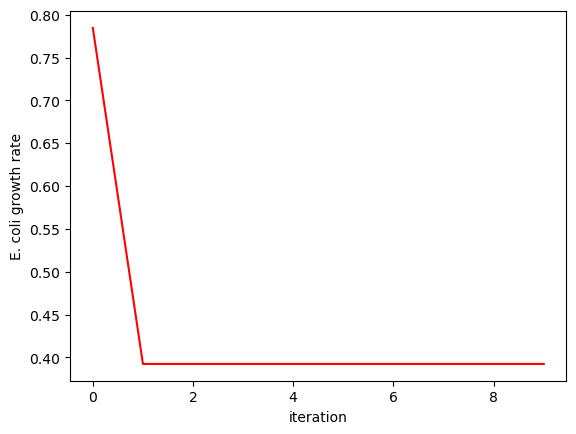

In [ ]:
import matplotlib.pyplot as plt
def single_flux_visual(F, flux_id, ):
    plt.plot(list(F[0][flux_id]),'r')
    plt.xlabel('iteration')
    plt.ylabel('Flux Value')     

single_flux_visual(F_test, "biomass525")

def 

## Store Vals

In [ ]:
def store(path, type="pkl"):

## Auxotrophic Analysis

In [1]:
def aux_analysis(model):
    exchange = [] # Keep track of exchanges
    relative_growth = [] # Keep track of relative growth rate (how well does the model grow without this metabolite vs with the metabolite)

    # turn on model exchanges
    for ex in model.exchanges:
        ex.lower_bound = -1000
        ex.upper_bound = 1000

    # turn off O2 for base anaerobic growth
    model.exchanges.get_by_id('EX_o2(e)').lower_bound = 0 # turn off oxygen uptake (anaerobic)

    # calculate the base growth rate, with all nutrients available, using FBA
    base_solution = model.slim_optimize() 
    if base_solution < 0.01: # print a warning if the model didn't grow with all nutrients
        print('base solution low')
        
    for ex in model.exchanges: # for each exchange reaction
        ex_id = ex.id
        
        with model as model1: 
            model1.reactions.get_by_id(ex_id).lower_bound = 0  # turn off uptake
            aux_solution = model.slim_optimize()  # recalculate growth rate
            rel_gro = (aux_solution-base_solution)/base_solution # calculate relative growth change
            exchange.append(ex_id) # save exchange id
            relative_growth.append(rel_gro) # save relative growth change

    # Save essential metabolite ids for later (these are the metabolites that when removed cause a greater than 90% reduction in growth)
    essential_inds = np.argwhere(np.array(relative_growth)<-0.9)
    essentials = np.array(exchange)[essential_inds]

    return essentials